# Figure 5: Leading authors

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import stat_lib

from pathlib import Path
# Create directory structure if it doesn't exist
Path(f"figures/figure_tables").mkdir(parents=True, exist_ok=True)


import plot_info # Does this set the plot style ? Yes it does
import wrangling

assessment_columns = plot_info.assessment_columns

leading_author_claims = pd.read_csv("preprocessed_data/leading_author_claims.csv")
author_metrics = wrangling.create_author_metric(claim_df = leading_author_claims,
                                                variable= "leading_author_key",
                                                other_col={"Leading Author Name":('Leading Author Name', 'first')},)
author_metrics_after_2000 = wrangling.create_author_metric(
                                                claim_df=leading_author_claims[leading_author_claims['year'] > 2000], 
                                                variable= "leading_author_key", 
                                                other_col={"Leading Author Name":('Leading Author Name', 'first')},)


In [2]:
author_metrics

,leading_author_key,Major claims,Articles,Leading Author Name,Challenged,Mixed,Partially Verified,Unchallenged,Verified,Unchallenged prop,Verified prop,Partially Verified prop,Mixed prop,Challenged prop
0,agaisse h,3,1,Agaisse H,0,0,0,2,1,0.666667,0.333333,0.000000,0.0,0.0
1,aguilera rj,2,1,Aguilera RJ,1,0,0,0,1,0.000000,0.500000,0.000000,0.0,0.5
2,aigaki t,3,1,Aigaki T,0,0,0,2,1,0.666667,0.333333,0.000000,0.0,0.0
3,anderson kv,20,8,Anderson KV,2,0,0,7,11,0.350000,0.550000,0.000000,0.0,0.1
4,ando i,12,6,Andó I,0,0,4,1,7,0.083333,0.583333,0.333333,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,xu t,3,1,Xu T,0,0,0,0,3,0.000000,1.000000,0.000000,0.0,0.0
152,yamaguchi m,2,1,Yamaguchi M,0,0,0,1,1,0.500000,0.500000,0.000000,0.0,0.0
153,yoo ma,3,1,Yoo MA,0,0,1,0,2,0.000000,0.666667,0.333333,0.0,0.0
154,yu xq,3,1,Yu XQ,0,0,0,1,2,0.333333,0.666667,0.000000,0.0,0.0


In [3]:
leading_author_claims.columns

Index(['id', 'content', 'article_id', 'rank', 'pmid', 'authors_txt', 'title',
       'pmid_article', 'volume', 'issue', 'abstract', 'year', 'journal_name',
       'impact_factor', 'first_author_extracted', 'last_author_extracted',
       'primary_affiliation', 'country', 'assertion_type', 'label',
       'is_assessed', 'assessment_type', 'rank_assessment_type',
       'shangai_ranking_2010', 'assessment_type_grouped', 'author_id', 'name',
       'leading_author', 'first_author', 'career_stage', 'expertise_level',
       'author_key', 'Leading Author Name', 'Historical lab',
       'Historical lab after 1998', 'Continuity', 'F and L',
       'Leading Author Sex', 'Start lab', 'Finish', 'Authorship',
       'leading_author_key', 'Junior Senior'],
      dtype='object')

In [4]:
print(len(author_metrics))
# TODO update all with this ?
print(len(author_metrics))

156
156


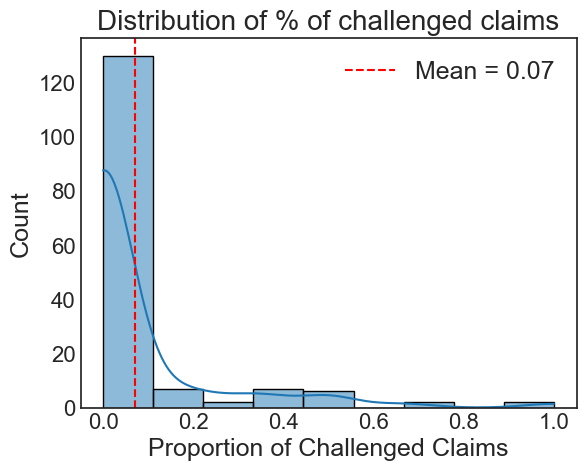

Descriptive Statistics:


,Unchallenged,Verified,Partially Verified,Mixed,Challenged,Unchallenged prop,Verified prop,Partially Verified prop,Mixed prop,Challenged prop,Challenged prop,Articles,Major claims
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,1.538462,3.910256,0.480769,0.076923,0.442308,0.280872,0.572245,0.062844,0.013642,0.070396,0.070396,2.564103,6.448718
std,2.301149,6.723451,0.973661,0.331924,1.096860,0.322156,0.340278,0.137738,0.064930,0.176316,0.176316,3.483009,9.166063
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
50%,1.000000,2.000000,0.000000,0.000000,0.000000,0.200000,0.625000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
75%,2.000000,4.000000,1.000000,0.000000,0.000000,0.500000,0.878472,0.066667,0.000000,0.000000,0.000000,2.000000,6.000000
max,17.000000,47.000000,6.000000,2.000000,7.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,28.000000,67.000000


In [5]:
descriptive_stats = author_metrics[assessment_columns + [col + ' prop' for col in assessment_columns] + 
                    ['Challenged prop', 'Articles', 'Major claims']].describe()

sns.histplot(author_metrics['Challenged prop'], kde=True)
plt.title('Distribution of % of challenged claims')
plt.xlabel('Proportion of Challenged Claims')
plt.axvline(author_metrics['Challenged prop'].mean(), color='red', linestyle='--', 
            label=f'Mean = {author_metrics["Challenged prop"].mean():.2f}')
plt.legend()
plt.show()
print("Descriptive Statistics:")
descriptive_stats

## A. Distribution plot

Our analysis will focus on the 156 PIs who published at least 0 major claims from aminimum of 0 articles
Among the 156 PIs, we identified 26 laboratories where more than 10% of the claims were challenged, with the highest proportion reaching 100.0% 


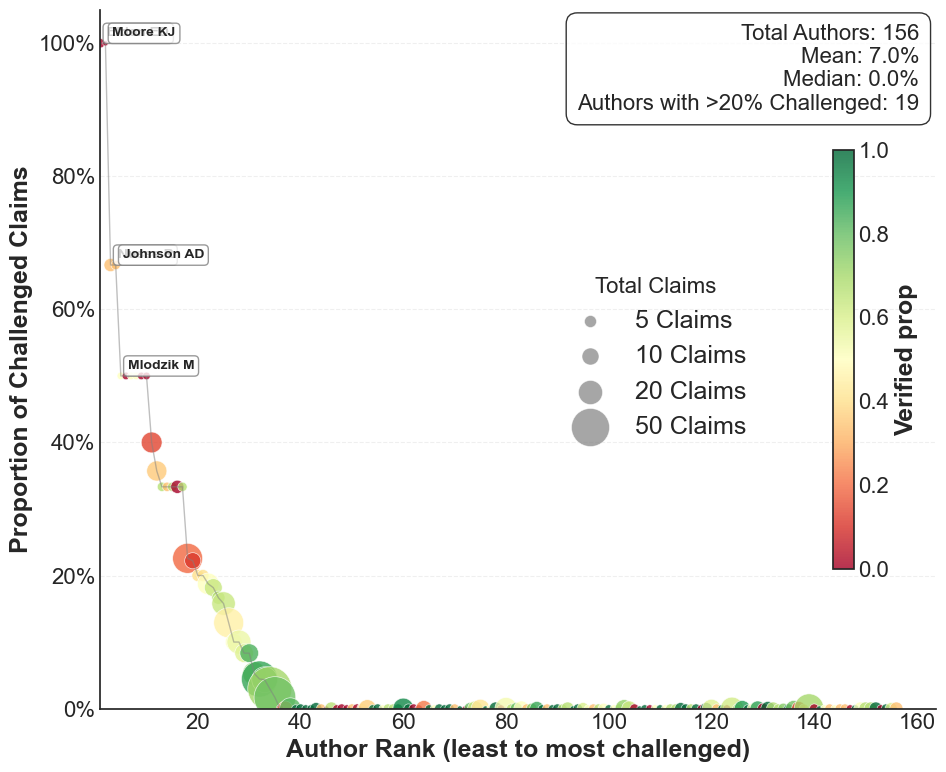

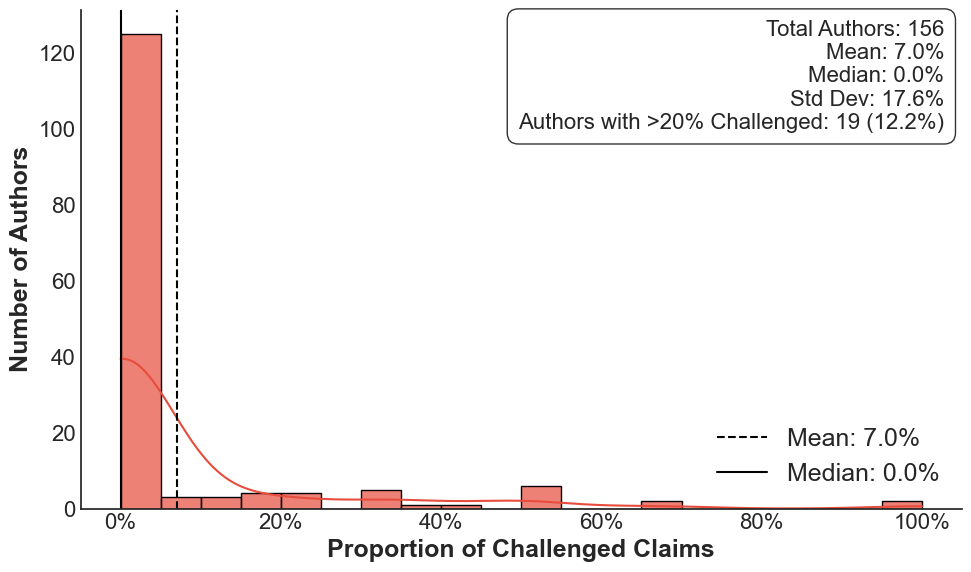

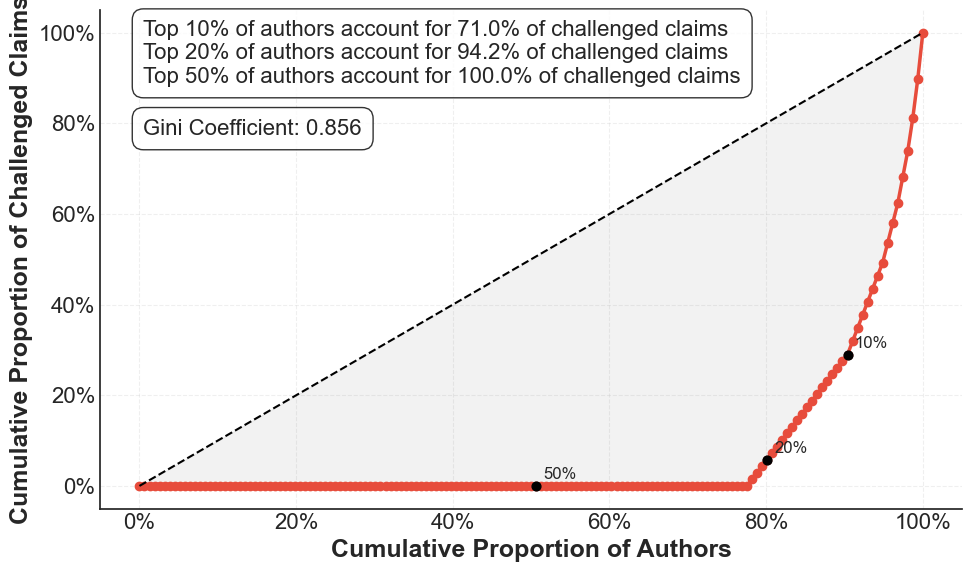

In [6]:
to_plot = author_metrics.copy()
min_articles = 0
min_claims = 0
to_plot = to_plot[to_plot['Articles'] >= min_articles]
to_plot = to_plot[to_plot['Major claims'] >= min_claims]
print(f"Our analysis will focus on the {len(to_plot)} PIs who published at least {min_claims} major claims from a"
      f"minimum of {min_articles} articles")
print(f"Among the {len(to_plot)} PIs, we identified {len(to_plot[to_plot['Challenged prop']>.1])} laboratories "
      f"where more than 10% of the claims were challenged, with the highest proportion reaching"
      f" {max(to_plot['Challenged prop']*100)}% ")


fig, ax = plot_info.plot_author_irreproducibility_focused(
    df=to_plot,
    title="",
    color_by='Verified prop',
    cmap='RdYlGn',  # Choose colormap that doesn't have white at minimum
    most_challenged_on_right=True,
    name_col='Leading Author Name',
)
plt.savefig('figures/fig6A_distribution_scatter.png', dpi=300, bbox_inches='tight')
fig1, ax1 = plot_info.plot_challenged_histogram(to_plot,title="",)
#plt.savefig('figures/fig5A-V2.png', dpi=300, bbox_inches='tight')

# Create Lorenz curve visualization
fig2, ax2 = plot_info.plot_lorenz_curve(to_plot,
                                        title="",)
plt.savefig('figures/fig6B_distribution_gini.png', dpi=300, bbox_inches='tight')

In [7]:
author_metrics

,leading_author_key,Major claims,Articles,Leading Author Name,Challenged,Mixed,Partially Verified,Unchallenged,Verified,Unchallenged prop,Verified prop,Partially Verified prop,Mixed prop,Challenged prop
0,agaisse h,3,1,Agaisse H,0,0,0,2,1,0.666667,0.333333,0.000000,0.0,0.0
1,aguilera rj,2,1,Aguilera RJ,1,0,0,0,1,0.000000,0.500000,0.000000,0.0,0.5
2,aigaki t,3,1,Aigaki T,0,0,0,2,1,0.666667,0.333333,0.000000,0.0,0.0
3,anderson kv,20,8,Anderson KV,2,0,0,7,11,0.350000,0.550000,0.000000,0.0,0.1
4,ando i,12,6,Andó I,0,0,4,1,7,0.083333,0.583333,0.333333,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,xu t,3,1,Xu T,0,0,0,0,3,0.000000,1.000000,0.000000,0.0,0.0
152,yamaguchi m,2,1,Yamaguchi M,0,0,0,1,1,0.500000,0.500000,0.000000,0.0,0.0
153,yoo ma,3,1,Yoo MA,0,0,1,0,2,0.000000,0.666667,0.333333,0.0,0.0
154,yu xq,3,1,Yu XQ,0,0,0,1,2,0.333333,0.666667,0.000000,0.0,0.0


## B. Binary variables

Actual groups found: [False, True]

Leading Author Historical lab after 1998  false vs true was not significantly associated with claim reproducibility (p = 0.08);
  8.7% (95% CI 8.6–8.7%) vs 5.0% (95% CI 4.9–5.0%) of claims were challenged for False vs True, respectively. 
 Odds Ratio = 1.82 (95% CI 0.95–3.47).

Summary of Historical lab after 1998:
                           Major claims  Articles  Verified_prop  \
Historical lab after 1998                                          
False                               578       232       0.513841   
True                                242        93       0.727273   

                           Challenged_prop  Unchallenged_prop  n_authors  
Historical lab after 1998                                                 
False                             0.086505           0.311419        117  
True                              0.049587           0.136364         27  
Actual groups found: [False, True]

Leading Author Continuity  false vs tr

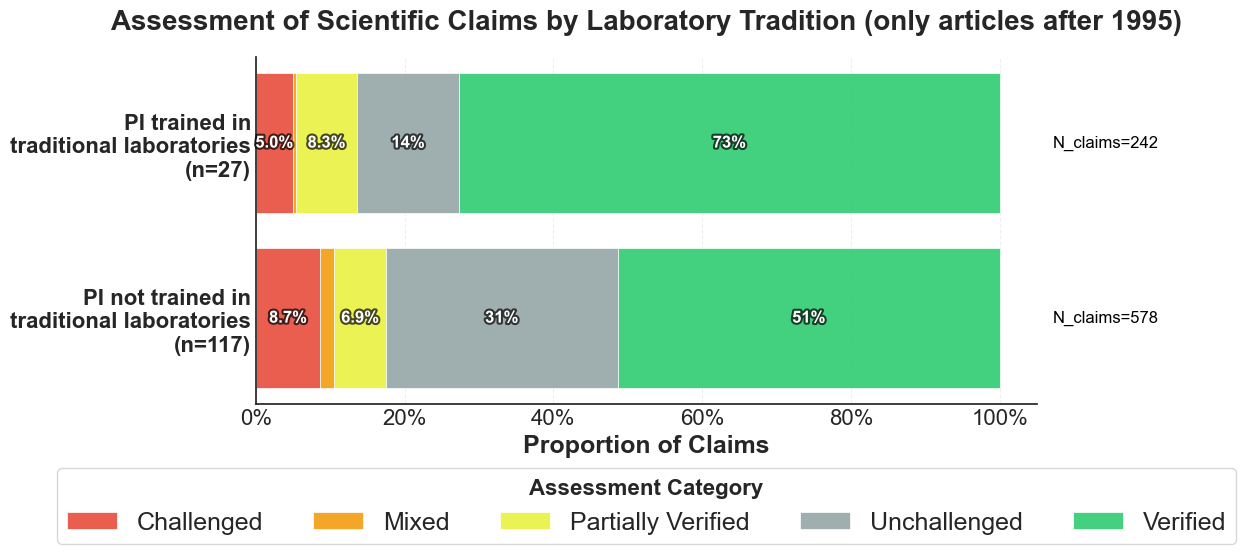

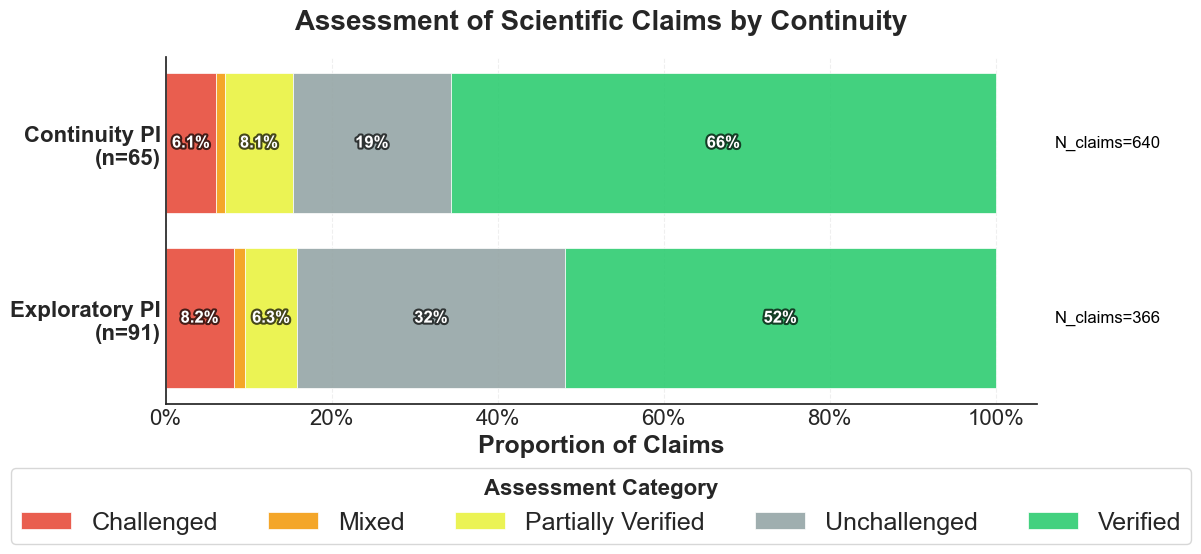

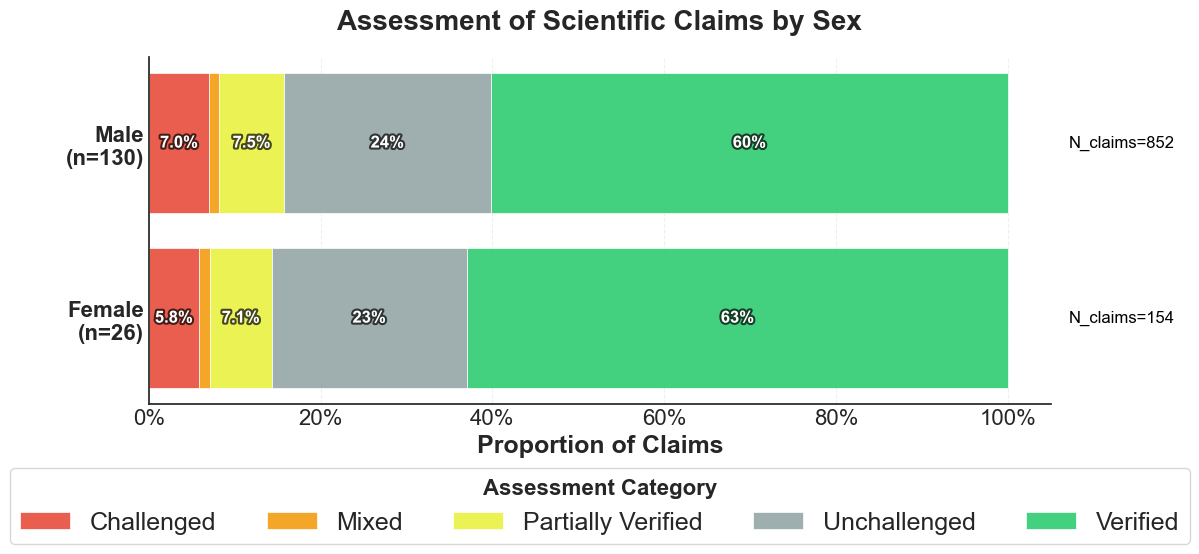

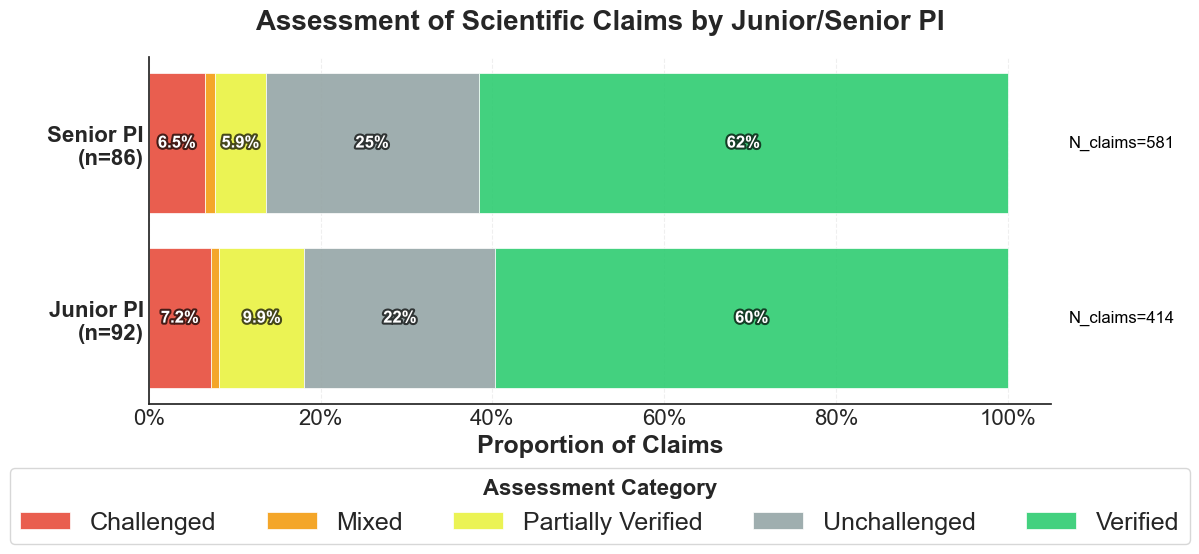

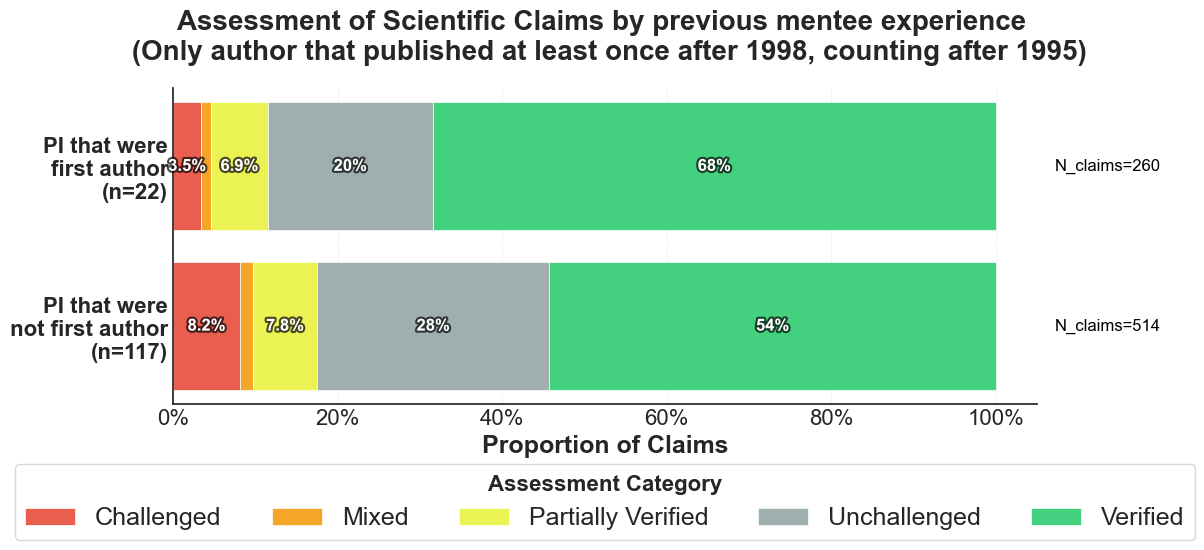

In [8]:
all_categorical_variables = {
            "Historical lab after 1998": {
                "labels": {
                    False:'PI not trained in\ntraditional laboratories', 
                    True:'PI trained in\ntraditional laboratories'},
                "title": "Assessment of Scientific Claims by Laboratory Tradition (only articles after 1995)",
                "fig_name_prefix" : "fig8C_"
                },
            "Continuity": {
                "labels": {
                    False:'Exploratory PI', 
                    True:'Continuity PI'},
                "title": "Assessment of Scientific Claims by Continuity",
                "fig_name_prefix" : "fig9A_"
                },
            "Leading Author Sex": {
                "labels" : None,
                "title": "Assessment of Scientific Claims by Sex",
                "fig_name_prefix" : "fig7A_",
                },
            "Junior Senior": {
                "labels": None,
                "title": "Assessment of Scientific Claims by Junior/Senior PI",
                "fig_name_prefix" : "fig7C_"
                },
            "F and L": {
                "labels": {
                    False:"PI that were\nnot first author", 
                    True:"PI that were\nfirst author"},
                "title": "Assessment of Scientific Claims by previous mentee experience \n (Only author that published at least once after 1998, counting after 1995)",
                "fig_name_prefix" : "fig8B_"
                },
            #"expertise_level": {
            #    "labels": ["Newcomer", "Experienced"],
            #    "title": "Assessment of Scientific Claims by Experience",
            #    "fig_name_prefix" : "fig??_"
            #},
        }

all_comparisons = []

for variable in all_categorical_variables.keys():
    # Group by historical lab status
    if variable == "Historical lab after 1998" or variable == "F and L":
        leading_author_claims_to_plot = leading_author_claims[leading_author_claims['year'] > 1995]
    else:
        leading_author_claims_to_plot = leading_author_claims
    if variable == "F and L":
        # take into account only the author that published at least once once after 1998
        author_to_keep = leading_author_claims[leading_author_claims['year'] > 1998]['leading_author_key'].unique()
        leading_author_claims_to_plot = leading_author_claims_to_plot[leading_author_claims_to_plot['leading_author_key'].isin(author_to_keep)]


    # This is wrong because it tooks the first value of variable for each author
    # am = wrangling.create_author_metric(claim_df = leading_author_claims_to_plot, 
    #                                     variable= "leading_author_key",
    #                                     other_col={"Name":('Name', 'first'),
    #                                                 variable:(variable, 'first')},)
    # if variable != "Historical lab after 1998":
    #     am = am[(am["Major claims"] >= 6) & (author_metrics["Articles"] >= 2)]
    # var_grouped = wrangling.group_categorical_variable(df=am, variable=variable,)
    
    # This was wrong because it overcounted claims when an author had different values for the same variable Utiliser pour les 2025-04-09
    # also this was filtered to only include authors with at least 6 major claims...
    #var_grouped2 = wrangling.prepare_categorical_variable_data(df=leading_author_claims, 
    #                                                author_metrics=author_metrics_to_plot, 
    #                                                variable=variable, 
    #                                                key_col='leading_author_key',
    #                                                assessment_columns=assessment_columns)


    var_grouped = wrangling.create_author_metric(claim_df = leading_author_claims_to_plot, 
                                        variable= variable,
                                        other_col={"Leading Author Name":('Leading Author Name', 'first'), "n_authors":('leading_author_key', 'nunique')}).set_index(variable)
    
    labels = all_categorical_variables[variable]["labels"]
    #if set(var_grouped.index) == set(labels):
    actual_groups = list(var_grouped.index)
    # Print to check if needed:
    print("Actual groups found:", actual_groups)
    if len(actual_groups) == 2:
        sentence, summary = stat_lib.report_categorical_comparison(var_grouped, 
                                                                        actual_groups, 
                                                                        outcome='Challenged',
                                                                        what_str=f"Leading Author {variable} ")
        print("\n"+sentence+"\n")
        all_comparisons.append({'Variable': variable, **summary})

    explain_df = leading_author_claims_to_plot.groupby(["Leading Author Name", variable]).agg(**{
        "Major claims":('id', 'count'),
        "Articles":('article_id', 'nunique')
        },
    ).reset_index().pivot(index="Leading Author Name", columns=variable, values="Major claims")
    explain_df.to_csv(f"figures/figure_tables/{all_categorical_variables[variable]['fig_name_prefix']}categorical_{variable}.csv", 
                    index=True, index_label=f"Name/{variable}", sep=";")

    # Calculate proportions
    for col in assessment_columns:
        var_grouped[f'{col}_prop'] = var_grouped[col] / var_grouped['Major claims']

    print(f"Summary of {variable}:")
    print(var_grouped[['Major claims', 'Articles', 
                        'Verified_prop', 'Challenged_prop', 'Unchallenged_prop', 'n_authors']])

    fig, ax = plot_info.create_horizontal_bar_chart(var_grouped, 
                                                    show_p_value=False, 
                                                    labels_map=labels, 
                                                    title=all_categorical_variables[variable]["title"],
                                                    other_n={"authors": "n_authors"})

    plt.savefig(f"figures/{all_categorical_variables[variable]['fig_name_prefix']}categorical_{variable}.png", dpi=300, bbox_inches='tight')

comparison_df = pd.DataFrame(all_comparisons)
comparison_df.to_csv("figures/figure_tables/summary_categorical_comparisons_leading.csv", sep=";", index=False)



In [9]:
to_plot = author_metrics.copy()

In [10]:
to_plot['Articles'].sort_values(ascending=False)

63     28
78     21
62     16
77     12
123    12
       ..
1       1
19      1
20      1
72      1
0       1
Name: Articles, Length: 156, dtype: int64

/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_97946/3783312957.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = to_plot.groupby('Article_bin')['Challenged prop'].median()


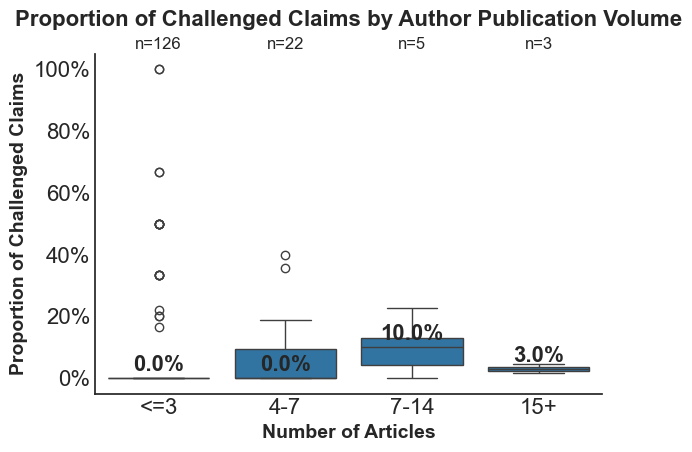

In [11]:

# Create article count bins
article_bins = [.5, 3.5, 7.5, 14.5,  float('inf')]
bin_labels =     ['<=3', '4-7', '7-14', '15+']
to_plot['Article_bin'] = pd.cut(to_plot['Articles'], bins=article_bins, labels=bin_labels)

# Create the boxplot
ax = sns.boxplot(x='Article_bin', y='Challenged prop', data=to_plot)
#ax = sns.stripplot(x='Article_bin', y='Challenged prop', data=to_plot, alpha=0.3, jitter=True, jitter_size=.95, color='black')

# Add individual data points
#sns.stripplot(x='Article_bin', y='Challenged prop', data=to_plot, 
#              color='black', alpha=0.3, jitter=True)

# Add count annotations below each category
for i, cat in enumerate(bin_labels):
    count = len(to_plot[to_plot['Article_bin'] == cat])
    ax.text(i, 1.05, f"n={count}", ha='center', va='top', fontsize=12,
            transform=ax.get_xaxis_transform())

# Format the y-axis as percentage
ax.yaxis.set_major_formatter(plot_info.PercentFormatter(1.0))

# Add labels and title
plt.xlabel('Number of Articles', fontsize=14, fontweight='bold')
plt.ylabel('Proportion of Challenged Claims', fontsize=14, fontweight='bold')
plt.title('Proportion of Challenged Claims by Author Publication Volume', 
          fontsize=16, fontweight='bold', pad=20)

# Add median values on top of each box
medians = to_plot.groupby('Article_bin')['Challenged prop'].median()
for i, m in enumerate(medians):
    ax.text(i, m + 0.01, f"{m:.1%}", ha='center', va='bottom', fontweight='bold')

# Remove top and right spines
sns.despine()

plt.tight_layout()
#plt.savefig('figures/fig5C-nb_article_V1.png', dpi=300, bbox_inches='tight')

In [12]:
to_plot

,leading_author_key,Major claims,Articles,Leading Author Name,Challenged,Mixed,Partially Verified,Unchallenged,Verified,Unchallenged prop,Verified prop,Partially Verified prop,Mixed prop,Challenged prop,Article_bin
0,agaisse h,3,1,Agaisse H,0,0,0,2,1,0.666667,0.333333,0.000000,0.0,0.0,<=3
1,aguilera rj,2,1,Aguilera RJ,1,0,0,0,1,0.000000,0.500000,0.000000,0.0,0.5,<=3
2,aigaki t,3,1,Aigaki T,0,0,0,2,1,0.666667,0.333333,0.000000,0.0,0.0,<=3
3,anderson kv,20,8,Anderson KV,2,0,0,7,11,0.350000,0.550000,0.000000,0.0,0.1,7-14
4,ando i,12,6,Andó I,0,0,4,1,7,0.083333,0.583333,0.333333,0.0,0.0,4-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,xu t,3,1,Xu T,0,0,0,0,3,0.000000,1.000000,0.000000,0.0,0.0,<=3
152,yamaguchi m,2,1,Yamaguchi M,0,0,0,1,1,0.500000,0.500000,0.000000,0.0,0.0,<=3
153,yoo ma,3,1,Yoo MA,0,0,1,0,2,0.000000,0.666667,0.333333,0.0,0.0,<=3
154,yu xq,3,1,Yu XQ,0,0,0,1,2,0.333333,0.666667,0.000000,0.0,0.0,<=3


### Continuous Variables

KeyError: 'Name'

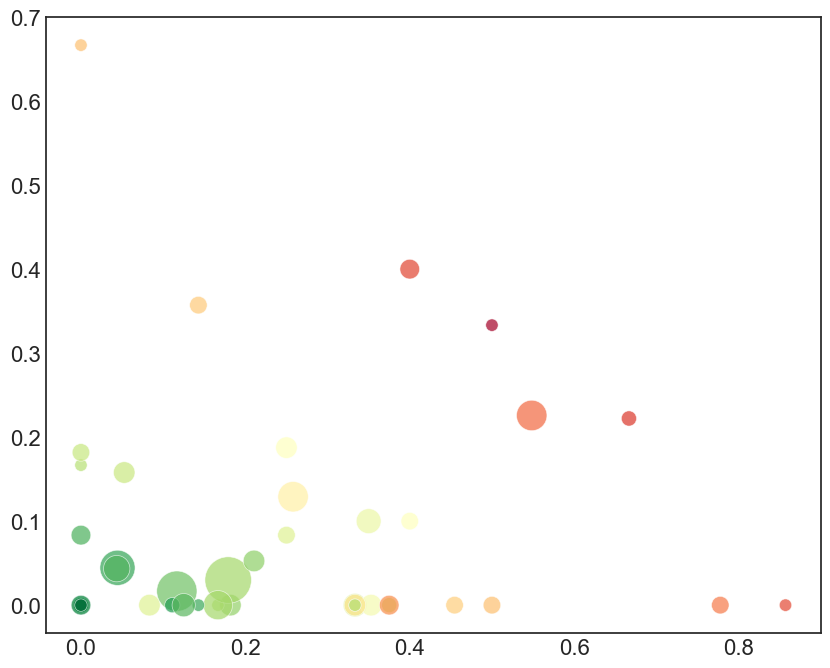

In [13]:
# just take the more than 2 articles annd 6 claims
to_plot = author_metrics.copy()
min_articles = 2
min_claims = 6
to_plot = to_plot[to_plot['Articles'] >= min_articles]
to_plot = to_plot[to_plot['Major claims'] >= min_claims]
fig1, ax1 = plot_info.create_challenged_vs_unchallenged_scatter(to_plot)
plt.savefig('figures/fig9B.png', dpi=300, bbox_inches='tight')

In [ ]:
to_plot

,last_author_key,Major claims,Articles,Name,Challenged,Mixed,Partially Verified,Unchallenged,Verified,Unchallenged prop,Verified prop,Partially Verified prop,Mixed prop,Challenged prop
3,anderson kv,20,8,Anderson KV,2,0,0,7,11,0.350000,0.550000,0.000000,0.000000,0.100000
4,ando i,12,6,Andó I,0,0,4,1,7,0.083333,0.583333,0.333333,0.000000,0.000000
23,courey aj,6,2,Courey AJ,0,1,1,0,4,0.000000,0.666667,0.166667,0.166667,0.000000
35,engstrom y,11,6,Engström Y,0,0,1,2,8,0.181818,0.727273,0.090909,0.000000,0.000000
36,ezekowitz ra,16,6,Ezekowitz RA,3,0,1,4,8,0.250000,0.500000,0.062500,0.000000,0.187500
37,fauvarque mo,8,3,Fauvarque MO,0,0,0,3,5,0.375000,0.625000,0.000000,0.000000,0.000000
40,ferrandon d,18,7,Ferrandon D,0,0,1,6,11,0.333333,0.611111,0.055556,0.000000,0.000000
43,franc nc,6,2,Franc NC,1,0,1,0,4,0.000000,0.666667,0.166667,0.000000,0.166667
46,gateff e,6,3,Gateff E,0,0,0,0,6,0.000000,1.000000,0.000000,0.000000,0.000000
47,gay nj,11,4,Gay NJ,2,2,0,0,7,0.000000,0.636364,0.000000,0.181818,0.181818


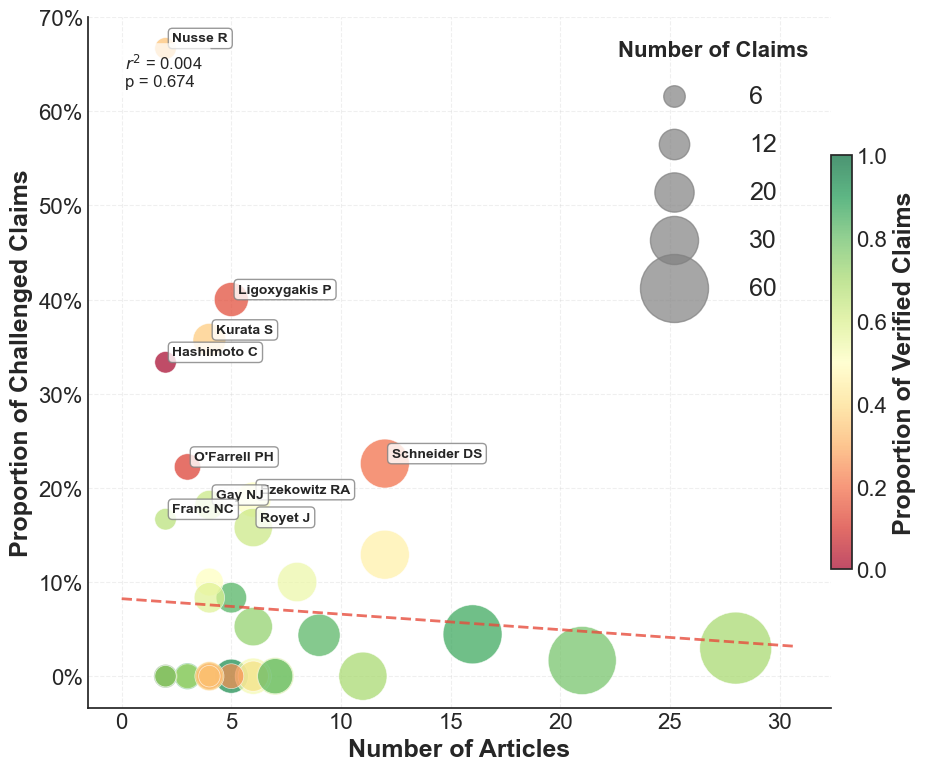

In [ ]:

fig2, ax2 = plot_info.create_challenged_vs_articles_scatter(to_plot,)
plt.savefig(f'figures/fig7B_scatterA.png', dpi=300, bbox_inches='tight')

<Axes: xlabel='Major claims'>

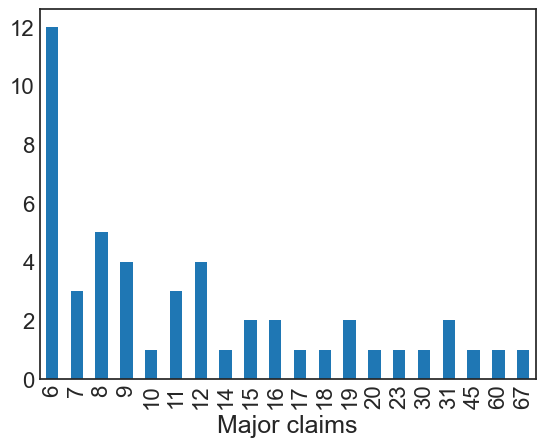

In [ ]:
to_plot["Major claims"].value_counts().sort_index().plot(kind='bar')    


<Axes: xlabel='Articles'>

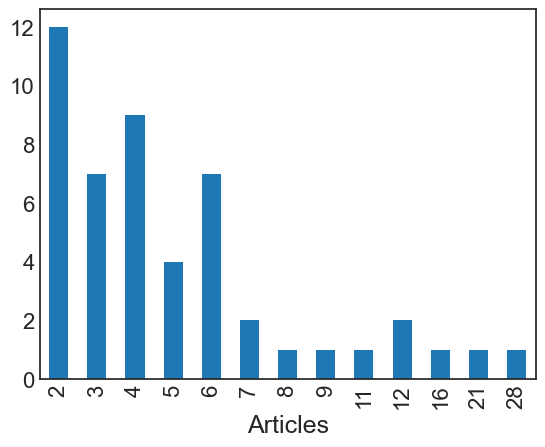

In [ ]:
to_plot["Articles"].value_counts().sort_index().plot(kind='bar')    

/Users/chadi/Research/drosophila-reproducibility/plot_info.py:1399: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


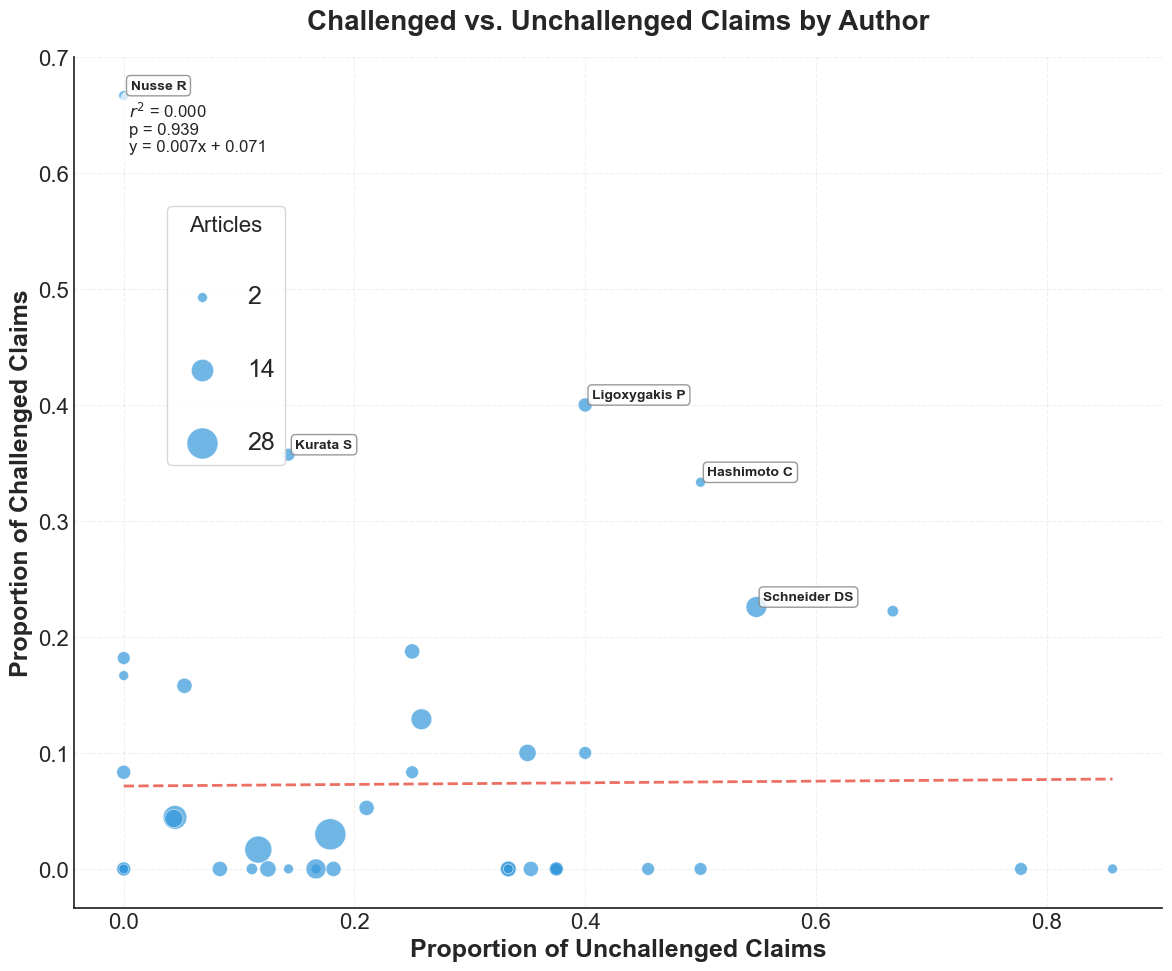

In [ ]:
# Example usage for general scatter plot:
fig, ax = plot_info.create_publication_scatter(
    to_plot,
    x_var='Unchallenged prop', 
    y_var='Challenged prop',
    size_var='Articles', 
    title='Challenged vs. Unchallenged Claims by Author',
    x_label='Proportion of Unchallenged Claims',
    y_label='Proportion of Challenged Claims',
    annotate_top_n=5
)
# plt.savefig(f'figures/fig6B_scatterB', dpi=300, bbox_inches='tight')

### Things that uses both

In [ ]:
first_author_claims = pd.read_csv("preprocessed_data/first_author_claims.csv")

In [ ]:
all_claims = pd.merge(first_author_claims, leading_author_claims, on='id', how='outer', suffixes=('_first', '_last'))

In [ ]:
import preprocess_utils


## B. Binary variables

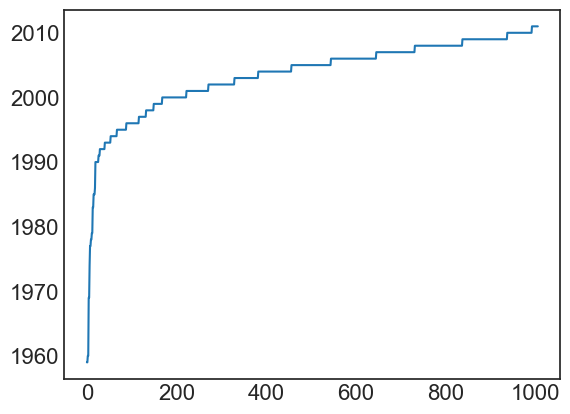

In [ ]:
first_papers_year = {}
claims_sorted = preprocess_utils.build_author_key(leading_author_claims, "authors_txt", "all_authors_key")
claims_sorted = claims_sorted.sort_values(by=['year']).reset_index(drop=True)
claims_sorted["year"].plot()
for lh in leading_author_claims["leading_author_key"].unique():
    found = False
    for idx, row in claims_sorted.iterrows():
        all_aut = row["all_authors_key"]
        authors_list = [aut.strip() for aut in all_aut.split(";")]
        if lh in authors_list:
            first_papers_year[lh] = row["year"]
            found = True
            break  # Break out of the inner loop once we find the first paper
    if not found:
        print(f"Warning: No papers found for author {lh}")
first_papers_year = pd.DataFrame.from_dict(first_papers_year, orient='index', columns=['first_paper_year'])

In [ ]:
to_plot = pd.merge(first_papers_year, author_metrics, left_index=True, right_on='leading_author_key', how='right')

/Users/chadi/Research/drosophila-reproducibility/plot_info.py:1399: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


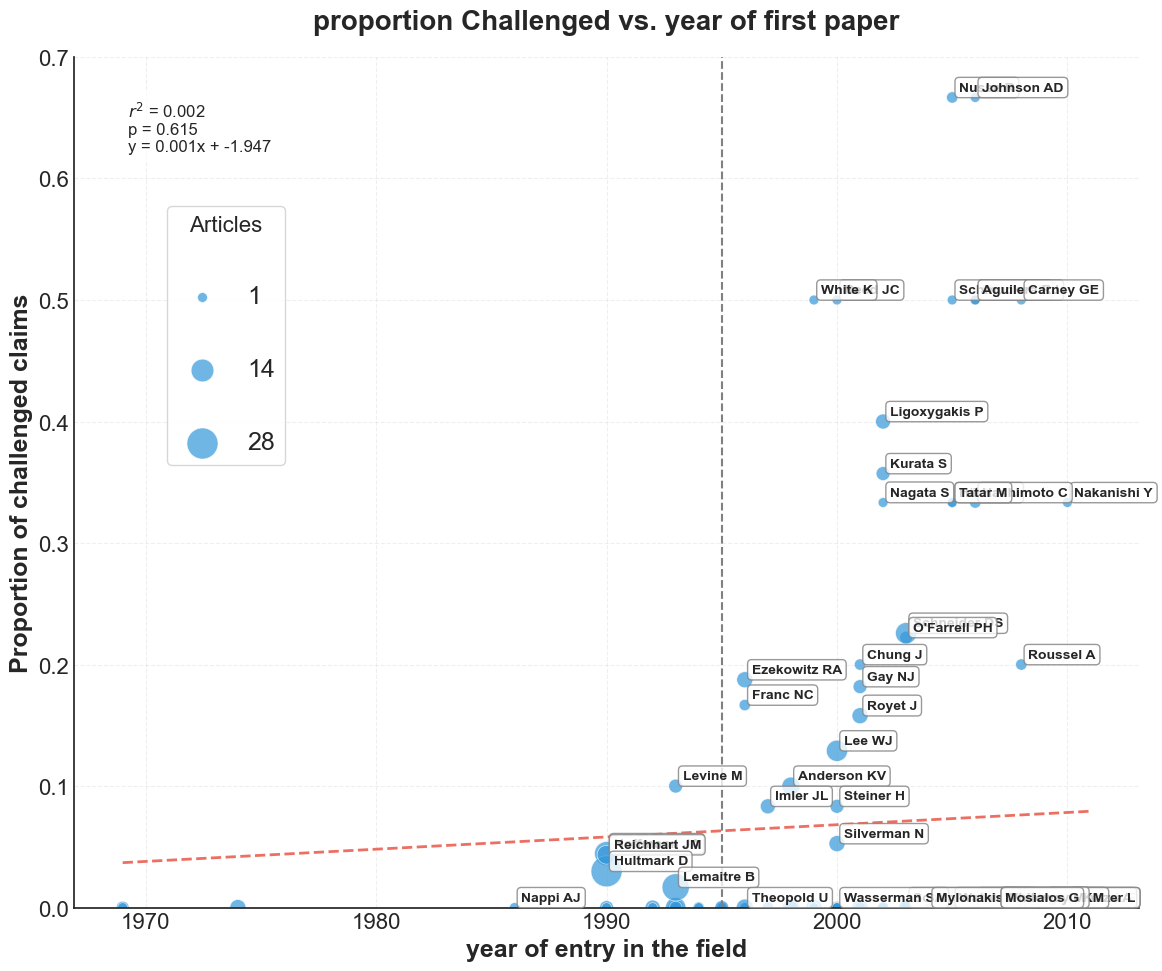

In [ ]:
fig, ax = plot_info.create_publication_scatter(
    to_plot,
    x_var='first_paper_year', 
    y_var='Challenged prop',
    size_var='Articles', 
    title='proportion Challenged vs. year of first paper',
    x_label="year of entry in the field",
    y_label="Proportion of challenged claims",
    annotate_top_n=50
)
ax.set_ylim(0, .7)
ax.vlines(x=1995, ymin=0, ymax=.7, color='grey', linestyle='--')
plt.savefig(f'figures/fig8A_YearVSRepro', dpi=300, bbox_inches='tight')

## Model

In [ ]:
# Create a multivariable regression model to predict reproducibility
# First, ensure no object datatypes are in our dataset by examining the data
print("Data types before preprocessing:")

# Convert any object columns to appropriate types
# Make sure all numeric columns are properly formatted
numeric_cols = ['Articles', 'Unchallenged_prop', 'Challenged_prop', 'Challenged_prop']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert boolean columns to integer
bool_cols = ['Historical lab', 'Continuity']
for col in bool_cols:
    df[col] = df[col].astype(int)
    
# Make sure categorical variables are properly typed
if 'Sex' in df.columns:
    df['Sex'] = df['Sex'].astype('category')
    
# Create dummy variables properly
df_model = pd.get_dummies(df[['Historical lab', 'Continuity', 'Ivy league', 
                             'Articles', 'Unchallenged_prop', 'Challenged_prop', 
                             'Challenged_prop']])

# Print data types after preprocessing
print("Data types after preprocessing:")
print(df_model.dtypes)

# Fit regression model for unchallenged proportion
# Select predictors (X) and target (y)
y = df_model['Unchallenged_prop']
X = df_model.drop(['Unchallenged_prop', 'Challenged_prop', 'Challenged_prop'], axis=1)

# Add constant
X = sm.add_constant(X)

# Verify no object datatypes remain
print("X dtypes:", X.dtypes.unique())
print("y dtype:", y.dtype)

# Fit model
try:
    model_unchallenged = sm.OLS(y, X).fit()
    print("Model successfully fit!")
    
    # Create another model for reproducibility score
    y2 = df_model['Challenged_prop']
    model_repro = sm.OLS(y2, X).fit()
    
    # Print summaries
    print("\nRegression Model for Unchallenged Proportion:")
    print(model_unchallenged.summary())
    
    print("\nRegression Model for Reproducibility Score:")
    print(model_repro.summary())
    
    # Create a visual summary of the regression results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Extract coefficients and confidence intervals for unchallenged model
    coefs1 = model_unchallenged.params[1:]
    conf_intervals1 = model_unchallenged.conf_int().iloc[1:]
    errors1 = (conf_intervals1[1] - conf_intervals1[0]) / 3.92  # 95% CI to standard error
    
    # Plot coefficients for unchallenged model
    ax1.errorbar(coefs1, range(len(coefs1)), xerr=errors1, fmt='o', capsize=5, color='#3498db')
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax1.set_yticks(range(len(coefs1)))
    ax1.set_yticklabels(coefs1.index)
    ax1.set_xlabel('Coefficient Value')
    ax1.set_title('Predictors of Unchallenged Claims')
    
    # Extract coefficients and confidence intervals for reproducibility model
    coefs2 = model_repro.params[1:]
    conf_intervals2 = model_repro.conf_int().iloc[1:]
    errors2 = (conf_intervals2[1] - conf_intervals2[0]) / 3.92  # 95% CI to standard error
    
    # Plot coefficients for reproducibility model
    ax2.errorbar(coefs2, range(len(coefs2)), xerr=errors2, fmt='o', capsize=5, color='#2ecc71')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_yticks(range(len(coefs2)))
    ax2.set_yticklabels(coefs2.index)
    ax2.set_xlabel('Coefficient Value')
    ax2.set_title('Predictors of Reproducibility Score')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error fitting model: {e}")
    print("Let's try an alternative approach using a simpler model")
    
    # Create a simpler model with fewer variables
    basic_vars = ['Articles', 'Historical lab', 'Continuity']
    df_simple = df[basic_vars + ['Unchallenged_prop']].copy()
    
    for col in basic_vars + ['Unchallenged_prop']:
        df_simple[col] = pd.to_numeric(df_simple[col], errors='coerce')
    
    # Drop missing values
    df_simple = df_simple.dropna()
    
    # Run simpler regression
    X_simple = sm.add_constant(df_simple[basic_vars])
    y_simple = df_simple['Unchallenged_prop']
    
    model_simple = sm.OLS(y_simple, X_simple).fit()
    print("\nSimplified Regression Model:")
    print(model_simple.summary())


Data types before preprocessing:


NameError: name 'df' is not defined